In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats

import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut
from importlib import reload

In [2]:
iniN = 3
endN = 48

src = '../hpcc/traditional/'
dst = src + 'results/'

filename = src + 'traditional_phenotype_summary.csv'
df = pd.read_csv(filename, dtype={1:str})
print(df.shape)

filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)

himalaya = 'NewStuke_R1_T18'
interest = df[df.bname == himalaya]
other = df[df.bname != himalaya]

cattraitnames = df.columns[endN:].values[[12,4,1,3,7,6,11,0,2]]

marker = ['o', 'v','*','^', 's', '<', 'X', '>', 'p', '8', 'h', 'H', 'D', 'd', 'P']
#col_wong = ['#e69f00', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#f0e442', '#56b4e9']
col_wong = ['#d81b60', '#1e88e5', '#ffc107', '#004d40', '#56e495']
col_wong += col_wong

(1264, 63)
(63, 2)


# ANOVA

In [3]:
def correct_zero(arr):
    minval = np.min(arr[np.nonzero(arr[:,1])[0], 1])
    arr[arr[:,1] == 0, 1] = minval
    return arr

In [4]:
ss = np.s_[:,iniN:endN]

F_onewayF= np.zeros((df.iloc[ss].shape[1], len(cattraitnames)))
KruskalH = np.zeros_like(F_onewayF)
F_onewayp= np.ones_like(F_onewayF)
Kruskalp = np.copy(F_onewayp)

for i in range(len(cattraitnames)):
    f_oneway, kruskal = wnut.anova(other, ss, cattraitnames[i])
    f_oneway = correct_zero(f_oneway)
    kruskal = correct_zero(kruskal)
    
    F_onewayF[:,i] = f_oneway[:,0]
    F_onewayp[:,i] = f_oneway[:,1]
    KruskalH[:,i]  = kruskal[:,0]
    Kruskalp[:,i] = kruskal[:,1]

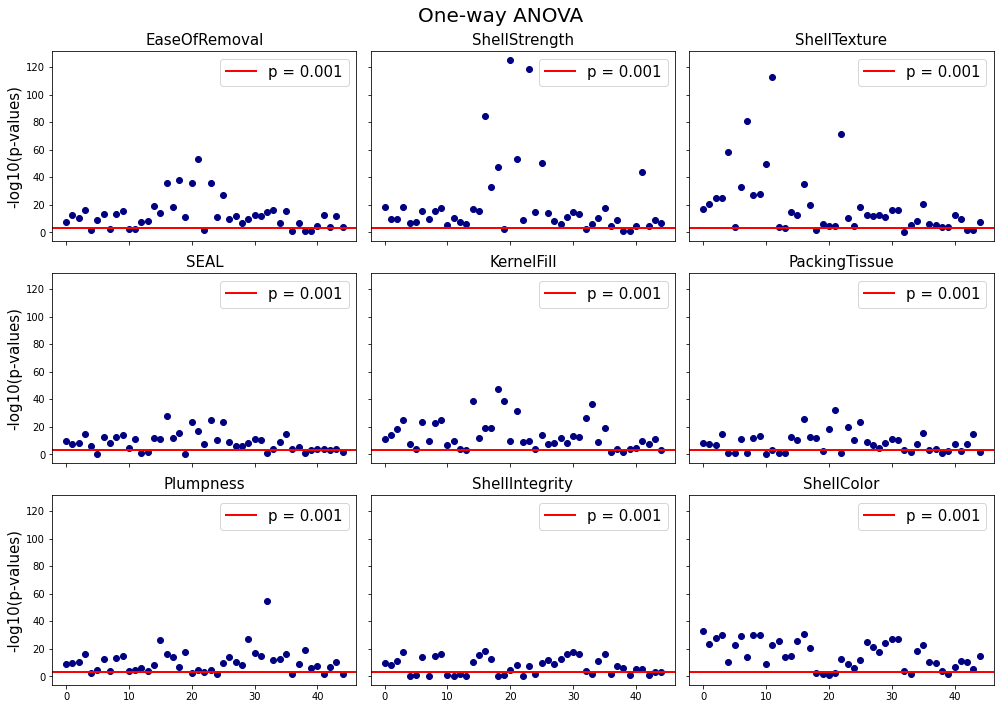

In [5]:
fig, ax = plt.subplots(3,3, figsize=(14,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
xvals = range(len(f_oneway))
fs = 15

for i in range(len(ax)):
    ax[i].scatter(xvals, -np.log10(F_onewayp[:,i]), c='navy')
    ax[i].axhline(y=-np.log10(0.05/50), c='red', lw=2, label='p = 0.001');
    ax[i].legend(fontsize=fs)
    ax[i].set_title(cattraitnames[i], fontsize=fs)

for i in [0,3,6]:
    ax[i].set_ylabel('-log10(p-values)', fontsize=fs);

fig.suptitle('One-way ANOVA', fontsize=20)
plt.tight_layout()

#filename = dst + 'ECT_ANOVA.jpg'
#plt.savefig(filename, bbox_inches='tight', dpi=100, format='jpg', pil_kwargs={'optimize':True})

../hpcc/traditional/results/KrukalWallis_traditional


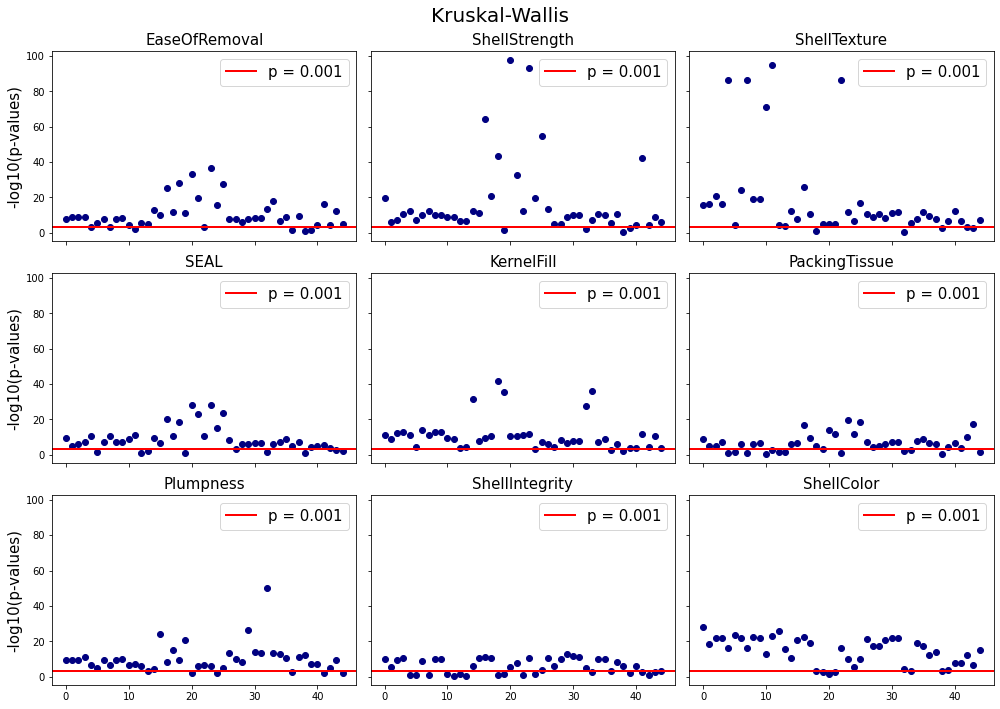

In [6]:
fig, ax = plt.subplots(3,3, figsize=(14,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
xvals = range(len(f_oneway))
fs = 15

for i in range(len(ax)):
    ax[i].scatter(xvals, -np.log10(Kruskalp[:,i]), c='navy')
    ax[i].axhline(y=-np.log10(0.05/50), c='red', lw=2, label='p = 0.001');
    ax[i].legend(fontsize=fs)
    ax[i].set_title(cattraitnames[i], fontsize=fs)

for i in [0,3,6]:
    ax[i].set_ylabel('-log10(p-values)', fontsize=fs);

fig.suptitle('Kruskal-Wallis', fontsize=20)
plt.tight_layout()

filename = dst + 'KrukalWallis_traditional'
print(filename)
plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=200, format='jpg', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', bbox_inches='tight', dpi=100, format='pdf')

In [7]:
def benjamini_hochberg(statistic, pvals, Q=1e-7):
    argpvals = np.lexsort((-statistic, pvals))
    
    bh_thr = np.arange(1,1+len(argpvals))*Q/len(argpvals)
    bh_critical = np.max(np.nonzero(pvals[argpvals] < bh_thr)[0])
    
    return bh_critical

../hpcc/traditional/results/KrukalWallis_BH_tratitional


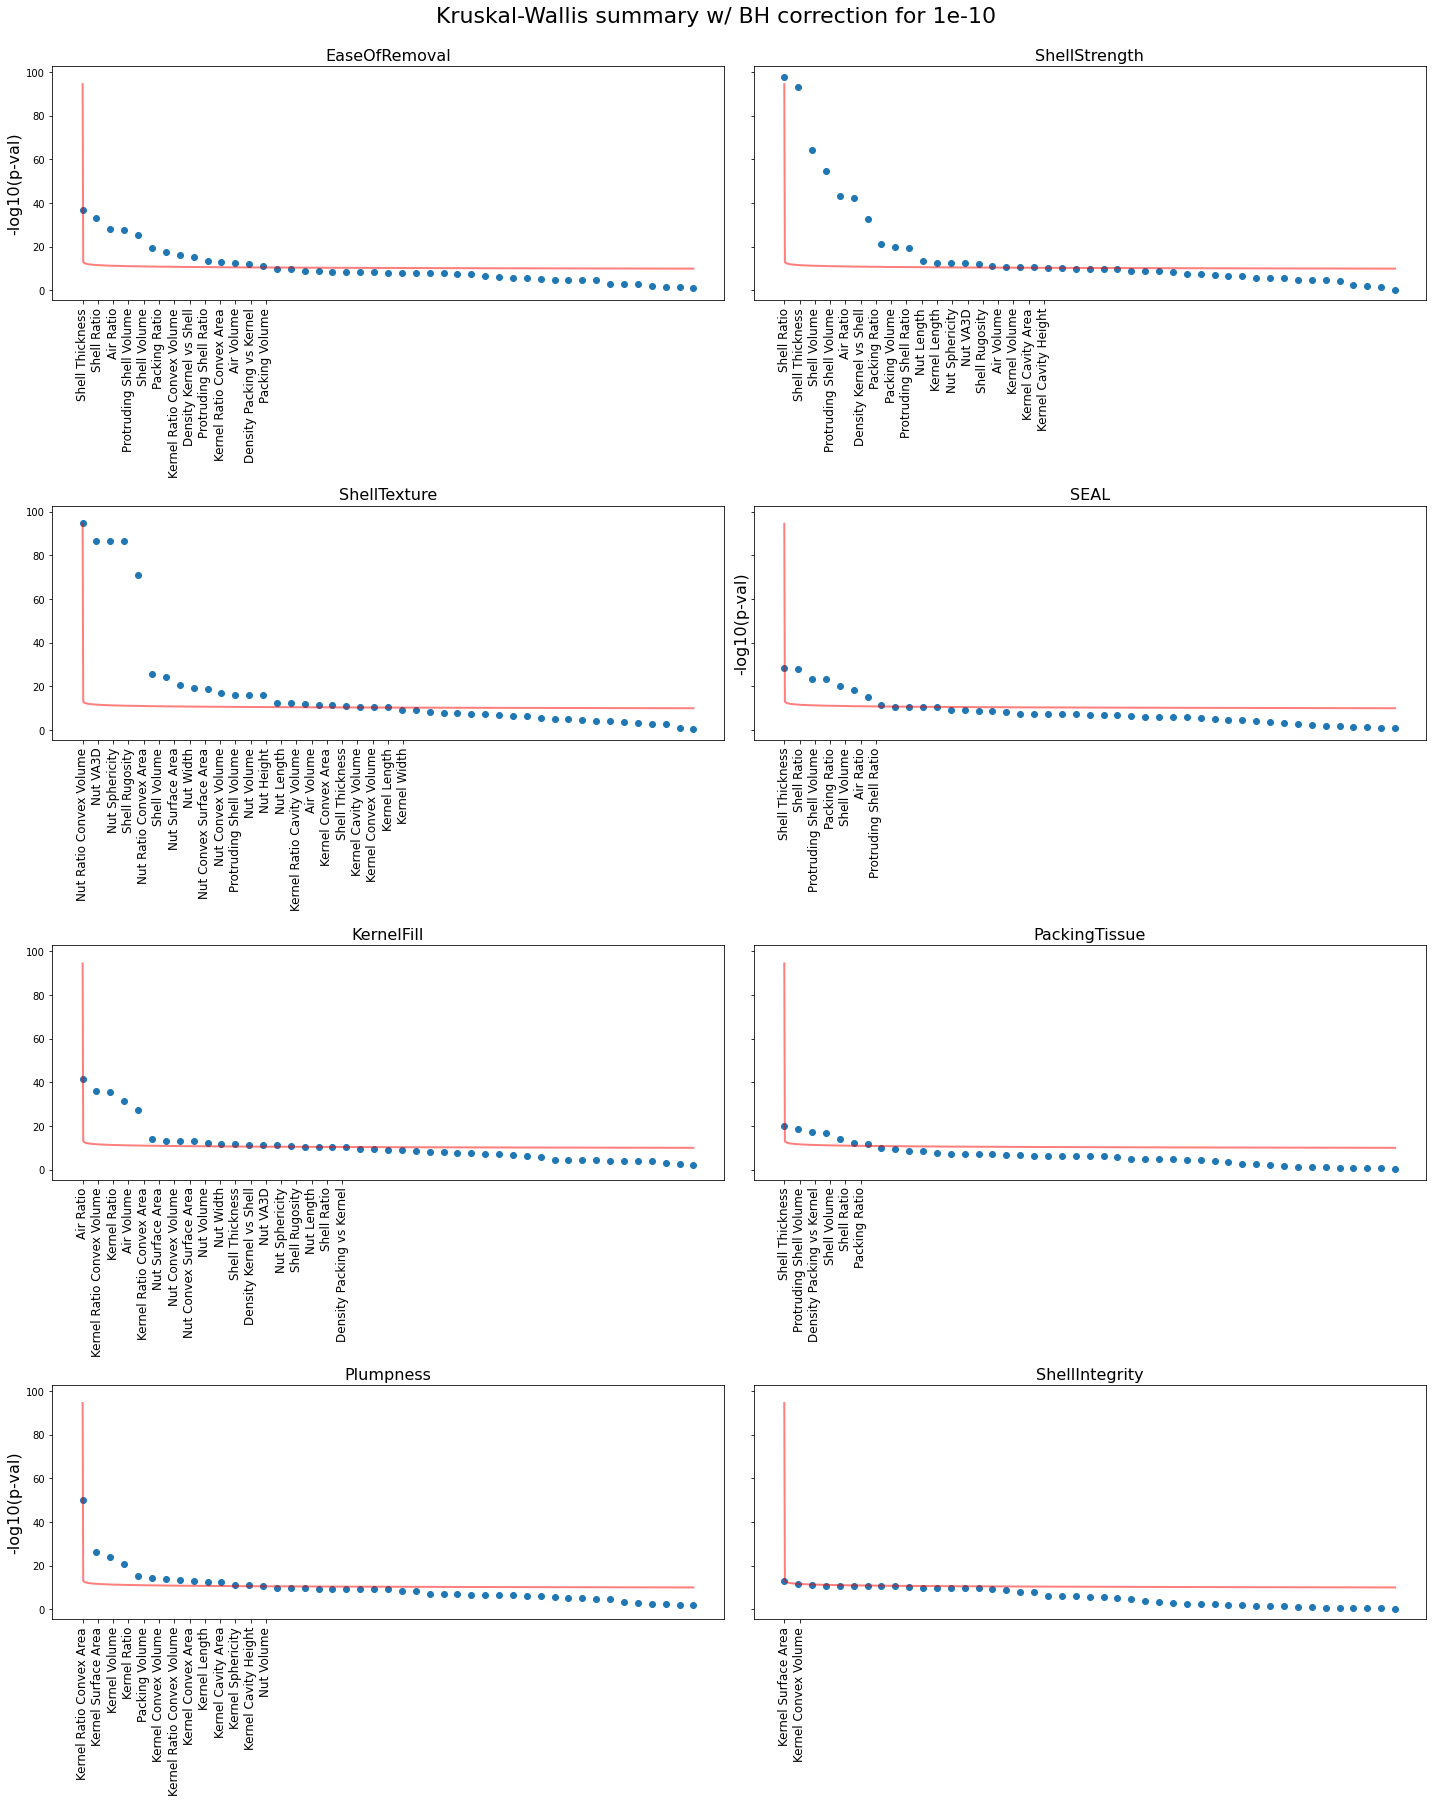

In [8]:
Q = 1e-10
fig, ax = plt.subplots(4,2,figsize=(20,25), sharey=True)
ax = np.atleast_1d(ax).ravel()
fs = 16
minval = np.min(Kruskalp)*1e15

for i in range(len(ax)):
    statistic = KruskalH[:,i]
    pvals     = Kruskalp[:,i]
    bh_critical = benjamini_hochberg(statistic, pvals, Q)
    
    argpvals = np.lexsort((-statistic, pvals))
    x = np.linspace(minval, len(argpvals)-1,1000)
    
    ax[i].set_title(cattraitnames[i], fontsize=fs)
    ax[i].plot(x, -np.log10(x*Q/len(argpvals)), lw=2, c='red', alpha=0.5)
    ax[i].scatter(np.arange(len(argpvals)), -np.log10(pvals[argpvals]))
    
    ax[i].set_xticks(np.arange(bh_critical)*1.1)
    ax[i].set_xticklabels(labels.col_labels.iloc[argpvals[:bh_critical] + iniN])
    ax[i].tick_params('x',labelsize=12,labelrotation=90)

for i in [0,3,6]:
    ax[i].set_ylabel('-log10(p-val)', fontsize=fs)
    #ax[i].legend(fontsize=fs-5)
    
fig.suptitle('Kruskal-Wallis summary w/ BH correction for {}'.format(Q), fontsize=22, y=1)
fig.tight_layout()

filename = dst + 'KrukalWallis_BH_tratitional'
print(filename)
#plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=100, format='jpg', pil_kwargs={'optimize':True})

In [50]:
fs = 21
for i in range(len(cattraitnames)):
#for i in [1]:
    cattraitname = cattraitnames[i]
    statistic = KruskalH[:,i]
    pvals     = Kruskalp[:,i]
    bh_critical = benjamini_hochberg(statistic, pvals, Q)

    argpvals = np.lexsort((-statistic, pvals))
    x = np.linspace(minval, len(argpvals)-1,1000)
    cattrait = np.sort(pd.unique(df[cattraitname]))[1:]
    cattrait = cattrait.astype(int)

    fig, ax = plt.subplots(3,4, figsize=(18,11), sharex=True)
    ax = np.atleast_1d(ax).ravel()
    traitidx = argpvals[:len(ax)] + iniN
    sl = labels.col_labels.iloc[argpvals[:len(ax)] + iniN].values
    ul = labels.col_units.iloc[argpvals[:len(ax)] + iniN].values

    for idx,i in enumerate(traitidx):
        trait_i = df.iloc[:,i].values
        boxplot = []
        for k in range(len(cattrait)):
            mask = df[cattraitname] == cattrait[k]
            ax[idx].scatter(np.random.default_rng().uniform(-1,1,np.sum(mask))*.33 + k,
                            trait_i[mask],
                            color=col_wong[k], marker=marker[k], s=60, alpha=0.25)
            boxplot.append(trait_i[mask])
        ax[idx].boxplot(boxplot, notch=False, sym='', vert=True, positions=range(len(cattrait)), widths=0.7,
                        medianprops = {'color':col_wong[-2], 'lw':4})
        ylabel = sl[idx] + ul[idx]
        
        ax[idx].set_ylabel(textwrap.fill(ylabel,22), fontsize=fs)
        ax[idx].set_xticks(range(len(cattrait)))
        ax[idx].set_xticklabels(cattrait)
        ax[idx].tick_params(labelsize=fs-4)


    fig.suptitle(cattraitname, fontsize=24)
    fig.tight_layout()

    filename = dst + 'qual_' + cattraitname + '_scatter'
    print(filename)
    plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close()

../hpcc/traditional/results/qual_EaseOfRemoval_scatter
../hpcc/traditional/results/qual_ShellStrength_scatter
../hpcc/traditional/results/qual_ShellTexture_scatter
../hpcc/traditional/results/qual_SEAL_scatter
../hpcc/traditional/results/qual_KernelFill_scatter
../hpcc/traditional/results/qual_PackingTissue_scatter
../hpcc/traditional/results/qual_Plumpness_scatter
../hpcc/traditional/results/qual_ShellIntegrity_scatter
../hpcc/traditional/results/qual_ShellColor_scatter


# Himalayan

In [56]:
kruskal = np.column_stack((np.zeros(endN - iniN), np.ones(endN - iniN)))
print(kruskal.shape)

l_anova = [None, None]

for i in range(len(kruskal)):
    j = i+iniN
    l_anova[0] = interest.iloc[:,j].values
    l_anova[1] = other.iloc[:,j].values

    foo = stats.kruskal(*l_anova)
    kruskal[i, :] = foo.statistic, foo.pvalue

kruskal = correct_zero(kruskal)

(45, 2)


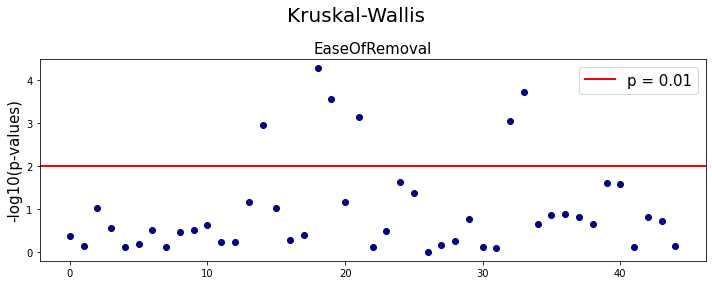

In [57]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
xvals = range(len(kruskal))
fs = 15

for i in range(len(ax)):
    ax[i].scatter(xvals, -np.log10(kruskal[:,1]), c='navy')
    ax[i].axhline(y=-np.log10(0.01), c='red', lw=2, label='p = 0.01');
    ax[i].legend(fontsize=fs)
    ax[i].set_title(cattraitnames[i], fontsize=fs)

for i in [0]:
    ax[i].set_ylabel('-log10(p-values)', fontsize=fs);

fig.suptitle('Kruskal-Wallis', fontsize=20)
plt.tight_layout()

../hpcc/traditional/results/KH_summary_85-023-2


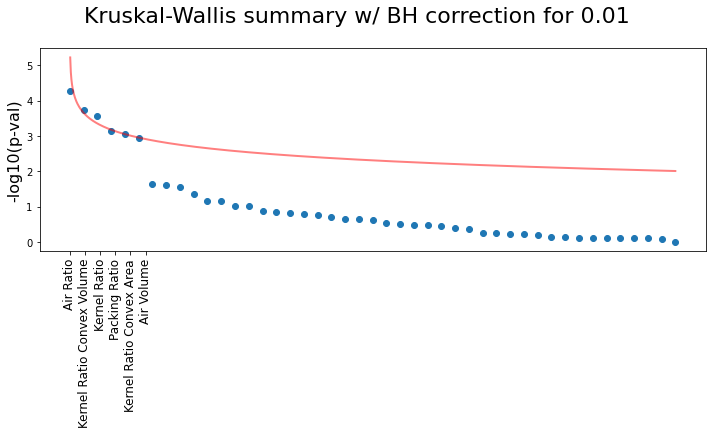

In [58]:
Q = 1e-2
fig, ax = plt.subplots(1,1,figsize=(10,6), sharey=True)
ax = np.atleast_1d(ax).ravel()
fs = 16
minval = np.min(kruskal[:,1])*5e2

for i in [0]:
    statistic = kruskal[:,0]
    pvals     = kruskal[:,1]
    bh_critical = benjamini_hochberg(statistic, pvals, Q) + 1
    
    argpvals = np.lexsort((-statistic, pvals))
    x = np.linspace(minval, len(argpvals)-1,1000)
    
    #ax[i].set_title(cattraitnames[i], fontsize=fs)
    ax[i].plot(x, -np.log10(x*Q/len(argpvals)), lw=2, c='red', alpha=0.5)
    ax[i].scatter(np.arange(len(argpvals)), -np.log10(pvals[argpvals]))
    
    ax[i].set_xticks(np.arange(bh_critical)*1.1)
    ax[i].set_xticklabels(labels.col_labels.iloc[argpvals[:bh_critical] + iniN])
    ax[i].tick_params('x',labelsize=12,labelrotation=90)

for i in [0]:
    ax[i].set_ylabel('-log10(p-val)', fontsize=fs)
    #ax[i].legend(fontsize=fs-5)
    
fig.suptitle('Kruskal-Wallis summary w/ BH correction for {}'.format(Q), fontsize=22, y=1)
fig.tight_layout()

filename = dst + 'KH_summary_' + '85-023-2'
print(filename)
plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=200, format='jpg', pil_kwargs={'optimize':True})
plt.savefig(filename + '.pdf', bbox_inches='tight', dpi=200, format='pdf')

In [59]:
pd.DataFrame(kruskal, columns=['H statistic', 'p value'], 
             index=labels.col_labels[iniN:endN].values).sort_values('H statistic', ascending=False)

,H statistic,p value
Air Ratio,16.290863,0.000054
Kernel Ratio Convex Volume,13.935605,0.000189
Kernel Ratio,13.205483,0.000279
Packing Ratio,11.387297,0.000739
Kernel Ratio Convex Area,11.010132,0.000906
Air Volume,10.620310,0.001119
Protruding Shell Ratio,5.142956,0.023341
Kernel Ratio Cavity Area,5.037732,0.024801
Kernel Ratio Cavity Volume,4.886230,0.027072
Protruding Shell Volume,4.060959,0.043886


../hpcc/traditional/results/qual_85-023-2_scatter


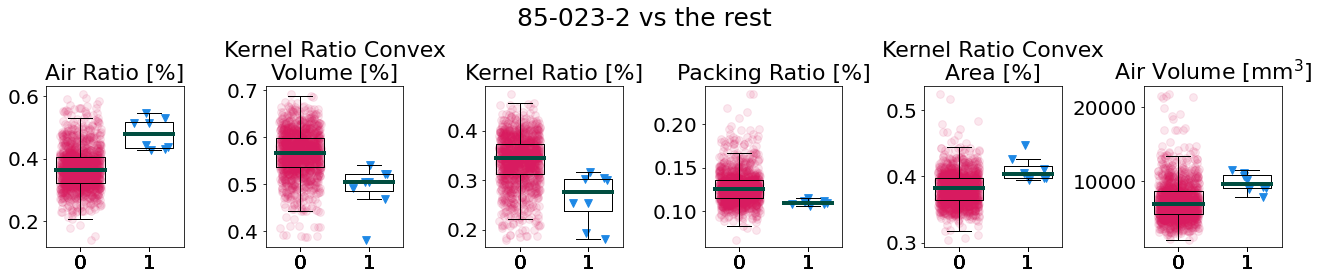

In [60]:
fs = 20
boxplot = [None, None]

xscatter = np.random.default_rng(12345).uniform(-1,1,len(df))*.3

#fig, ax = plt.subplots(2,6, figsize=(18,8), sharex=True)
fig, ax = plt.subplots(1,6, figsize=(18,4), sharex=True)
ax = np.atleast_1d(ax).ravel()

traitidx = argpvals[:len(ax)] + iniN
sl = labels.col_labels.iloc[argpvals[:len(ax)] + iniN].values
ul = labels.col_units.iloc[argpvals[:len(ax)] + iniN].values

for idx,i in enumerate(traitidx):
    boxplot[0] = other.iloc[:,traitidx[idx]].values
    boxplot[1] = interest.iloc[:,traitidx[idx]].values
    ax[idx].scatter(xscatter[:len(other)], boxplot[0], color=col_wong[0], marker=marker[0], s=60, alpha=0.1)
    ax[idx].scatter(xscatter[len(other):]+1, boxplot[1], color=col_wong[1], marker=marker[1], s=60, alpha=1)
    ax[idx].boxplot(boxplot, notch=False, sym='', vert=True, positions=range(2), widths=0.7,
                            medianprops = {'color':col_wong[-2], 'lw':4})
    
    ax[idx].set_title(textwrap.fill(labels.col_labels.iloc[i] + labels.col_units.iloc[i],20), fontsize=22)
    ax[idx].tick_params(labelsize=fs)

fig.suptitle("85-023-2 vs the rest", fontsize=25, y=0.96)
fig.tight_layout()

filename = dst + 'qual_' + '85-023-2' + '_scatter'
print(filename)
plt.savefig(filename + '.jpg', dpi=200, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.close()